# Modelling the molecular dynamics of Neon

In this notebook I will model the molecular dynamics of a Neon molecules using the Lenard-Jones potential to calculate the energy of the particles and the associated forces due to surrounding particles. The Lenard-Jones potential is used to describe the interactions between neutral atoms and molecules like Neon, the equation is given below:

Equation 1:
$$
V(r) = 4ϵ \left[ \left( \frac{σ}{r} \right)^{12}- \left( \frac{σ}{r}\right) ^6 \right]
$$

Where r is the distance between the particles and σ and ϵ are constants. The first term mimics the repulsion between molecules at short distances due to the electron clouds overlapping and the the second term is attractive and mimics the attractive Van der Waals force between molcules. 

For the interactions between Neon atoms the value of ϵ = 36$k_B$ where $k_B$ is the bolztmann constant and σ = 0.275nm, with the mass of a Neon atom $m = 1.673 \times 10^{27}$kg. 

To find and equation for the force between the atoms it is possible to differentiate this potential function with respect to r, in this case we get:

Equation 2:
$$
F_i (r_{ij}) = 24 ϵ {\bf r_{ij}} \left[\frac{σ^6}{r_{ij}^8} - 2 \frac{σ^{12}}{r_{ij}^{14}} \right]
$$

Where $F_i$ is the force on particle i due to particle j and ${\bf r_{ij}}$ is the distance vector from particle i to particle j. The value force on particle j due to particle i is simply the opposite so $F_j = - F_i$.

The kinetic energies may be found from the velocities of each of the particles, these energies may be summed to find the total kinetic energy of the model or they may be averaged to find $<E_k>$, which then allows us to find the temperature of the gas in the model using the equation below:

Equation 3:
$$
\frac{1}{2} mv^2= \frac{3}{2} k_B T
$$

Where T is the temperature and v is the average velocity of the atoms in the gas.

The values of force upon each of the atoms in the gas and their position allows us to use the Verlet algorithm to propogate the movement of the particles through time.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Creating a Force/Energy Function

This function will use the Lenard-Jones potential from eq. 1 to evaluate the potential energy of the system as well as eq. 2 to evaluate the resultant force on each of the particles in the system.

In [2]:
def LG_FEfinder(pos,N,sigma,epsilon,boxlen):
    """Finds the resultant force on each of the particles in the system-
    from the Lenard-Jones potential aswell as the total Lenard-Jones potential.
    Inputs:
    pos     particle positions (array, N x 3)
    N       number of particles (array, N)
    sigma   constant
    epsilon constant
    boxlen  side length of the model
    Returns:
    Ep      total LJ potential energy of system
    force   force on each particle (array, N x 3)"""
    
    #intialising
    force = np.zeros((N,3))
    Ep = 0.0
    sigma_3 = sigma*sigma*sigma
    sigma_6 = sigma_3*sigma_3
    
    #looping over particles
    for i in range(N-1):
        for j in range(i+1,N):
            dr = pos[j,:] - pos[i,:]
            dr -= boxlen*np.rint(dr/boxlen)
            dr_2 = np.sum(dr*dr)
            dr_i6 = 1/(dr_2 * dr_2 * dr_2)
            dr_i8 = dr_i6 * 1/dr_2
            fij = 24 * epsilon * dr * dr_i8 * sigma_6* (1 - 2*(sigma_6*dr_i6))
            force[i,:] += fij
            force[j,:] -= fij
            Ep += 4 * epsilon * sigma_6 * dr_i6 * (sigma_6*dr_i6 - 1)
            
    return force, Ep

### Setting up initial lattice and simulation parameters

This simulation will have 64 molecules in it, they will start equally spaced apart in a grid like state, this can be seen in Fig 1. below.

In [3]:
# Initialisation
Nsteps = 10000
kB = 1.381e-23         # J/K
sigma = 0.275e-9       #m
epsilon = 36*kB
mass = 20.2*1.673e-27  #kg
Ncells = 4
boxlen = 1.1*(2**(1/6))*sigma*Ncells  #m
Npart = Ncells*Ncells*Ncells
rbox3 = np.zeros([Nsteps,Npart,3])
vbox3 = np.zeros([Nsteps,Npart,3])
count = 0

#setting initial positions
for i in range(Ncells):
    for j in range(Ncells):
        for k in range(Ncells):
            rbox3[0,count,:] = (1/Ncells)*boxlen*np.array([i,j,k])
            count += 1

Text(0.5, 0, 'z')

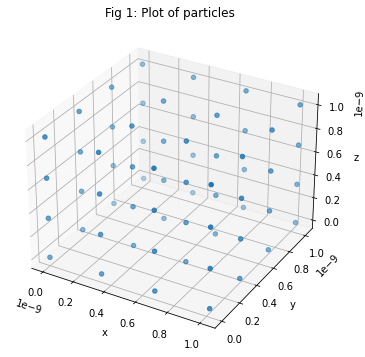

In [4]:
# plotting initial particle positions
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111,projection ='3d')
ax.scatter(rbox3[0,:,0],rbox3[0,:,1],rbox3[0,:,2])
ax.set_title('Fig 1: Plot of particles')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

### Initialising velocities and state variables

The velocities of these molecules at t = 0 will be set from a function that outputs numbers randomly from a normal distrubution and these velocities will then be scaled using a scaling factor to give the system an initial temperature of 50K. This will be done using the equation given below:

Equation 4:
$$
mC^2 \sum_{i=1}^{N} v_i^2 =3N k_B T 
$$

Where C is the scaling factor, $v_i$ is the velocity of particle i and N is the number of atoms in the model. This is a variation of Eq. 3 that has been re-arranged to give a scale factor to allow both sides of the equation to match.

In [5]:
#initialising velocities
initT  = 50 # K
vbox3[0] = np.random.normal(size=(Npart,3))
v_scale = np.sqrt(3*Npart*kB*initT/(mass*np.sum(vbox3[0]*vbox3[0])))
vbox3[0] *= v_scale

#initialising other parameters
energy = np.zeros(Nsteps)
temp = np.zeros(Nsteps)
f, e = LG_FEfinder(rbox3[0],Npart,sigma,epsilon,boxlen)
energy[0] = e
temp[0] = (mass*np.sum(vbox3[0]*vbox3[0]))/(3*kB*Npart)
acc = f/mass
dt = 1e-15 # s 
MSD = np.zeros(Nsteps)

### Running simulation

Within this step I will also calculate the mean squared displacement of all atoms at each time-step, this is calculated using the equation:

Equation 5:

$$
D(t)=\frac{1}{N}\sum_{i=1}^{N} ( {\bf r_i} (t)- {\bf r_i} (0))^2 
$$

Where D is the mean squared displacement function, t is the time and ${\bf r_i}$ is the position of atom i.

In [6]:
#verlet integration
for step in range(1,Nsteps):
    rbox3[step] = rbox3[step-1] + dt*vbox3[step-1] + 0.5*dt*dt*acc
    #applying periodic boundaries
    rbox3[step] = rbox3[step]%boxlen
    f, energy[step] = LG_FEfinder(rbox3[step],Npart,sigma,epsilon,boxlen)
    acc_next = f/mass
    vbox3[step] = vbox3[step-1] + 0.5*dt*(acc + acc_next)
    temp[step] = (mass*np.sum(vbox3[step]*vbox3[step]))/(3*kB*Npart)
    acc = acc_next
    #mean squared displacement
    MSD[step] = np.sum((rbox3[step]-rbox3[0])*(rbox3[step]-rbox3[0]))
MSD /= Npart

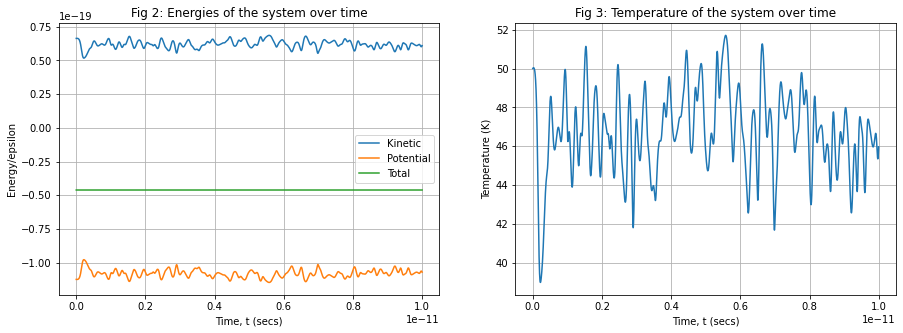

In [27]:
# plotting energy and temperature graphs
# these give an easy check for irregularities

time = dt*np.arange(1,Nsteps)
Ek = 0.5*mass*np.sum(vbox3*vbox3,axis=(1,2))

#plotting energies
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.plot(time,Ek[1:], label='Kinetic')
ax1.plot(time, energy[1:], label='Potential')
ax1.plot(time, (energy+Ek)[1:], label='Total')
ax1.legend()
ax1.set_xlabel('Time, t (secs)')
ax1.set_ylabel('Energy/epsilon')
ax1.set_title("Fig 2: Energies of the system over time")
ax1.grid()

#plotting temperature
ax2 = fig.add_subplot(122)
ax2.plot(time,temp[1:])
ax2.set_xlabel('Time, t (secs)')
ax2.set_ylabel('Temperature (K)')
ax2.set_title("Fig 3: Temperature of the system over time")
ax2.grid()

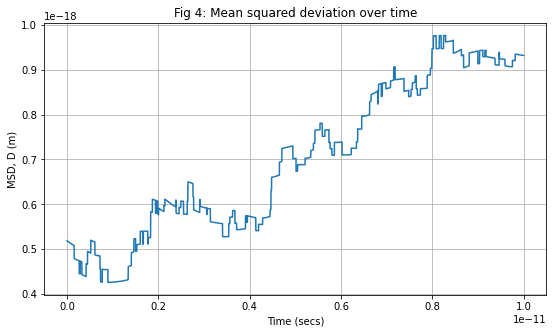

In [24]:
#plotting MSD against time
plt.figure(figsize=(9,5))
plt.plot(time,MSD[1:])
plt.title('Fig 4: Mean squared deviation over time')
plt.xlabel('Time (secs)')
plt.ylabel('MSD, D (m)')
plt.grid()

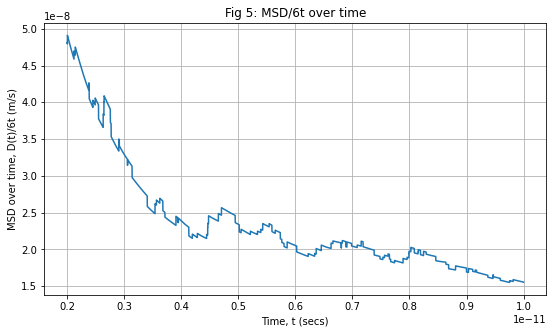

In [25]:
start = int(2e-12/dt) #start point at 2e-12 secs
plt.figure(figsize=(9,5))
plt.plot(time[start:],(MSD[start+1:]/(6*time[start:])))
plt.title('Fig 5: MSD/6t over time')
plt.xlabel('Time, t (secs)')
plt.ylabel('MSD over time, D(t)/6t (m/s)')
plt.grid()

Fig 5 above appears to show that the value to D(t)/6t converges towards between 1.5 and 1.6e-8 m/s as time goes on.

### Plotting the auto-correlation function

Using the data from above I am going to calculate the auto-correlation function to further analyse the model. This function takes the form:

Equation 6:

$$
I(t)=\frac{1}{3N} ∫_0^t \sum_{i=1}^{N} {\bf v_i} (t)⋅{\bf v_i} (0)dt
$$

Where N is the number of atoms in the model and t is the length of the model in seconds.

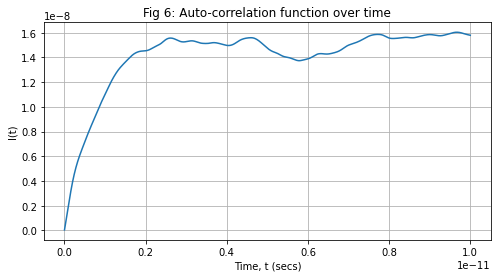

In [26]:
#rectangle integration
Int = np.zeros(Nsteps)
Int[0] = (np.sum(vbox3[0]*vbox3[0])*dt)/(3*Npart)
for step in range(1,Nsteps):
    Int[step] = Int[step-1] + (np.sum(vbox3[step]*vbox3[0])*dt)/(3*Npart)

#plotting
plt.figure(figsize=(8,4))
plt.plot(time,Int[1:])
plt.title('Fig 6: Auto-correlation function over time')
plt.xlabel('Time, t (secs)')
plt.ylabel('I(t)')
plt.grid()

From Fig 6 it is possible to say that the auto-correlation function converges to around 1.5 to 1.6e-8 as time increases. This value is almost identical to the convergence value seen above in Fig 5.

## Conclusion

From the data shown in the figures above I can conclude this model has been fairly successful, Fig's 2 & 3 both show the model works well with no large irregularities in the simulation, in Fig 2 the Total energy is almost perfectly constant showin energy in the model is well conserved and in Fig 3 the temperature averages around 42 and 50K which is where it was set. 

After calculating the MSD it was possible to see from Fig 4 that over time this increases steadily as would be expected from atoms performing brownian motion.

In Fig 5 the MSD/6t was plotted to account for the divergence in the 6 possible directions as time goes on, from the graph it was possible to see that this function converges towards 1.5 to 1.6e-8. This supports the ability of the model as this is an expected behvaiour for a gas. In Fig 6 the auto-correlation function was plotted which also converges towards a value of 1.5 to 1.6e-8 in agreement with Fig 5, these both support our current understanding of the behaviours of gases and so show the model to be successful.

To increase the accuracy of the model it could be run over a long time frame with more atoms in the system, this would bring the model closer to a real-world scenario.